## Importing the necessary libraries, packages and modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


### Storing data to appropriate variables

In [ ]:
train_data=pd.read_csv(r"D:\aml\AppliedMachineLearning\Assignment3\data\train.csv")
validate_data=pd.read_csv(r"D:\aml\AppliedMachineLearning\Assignment3\data\validation.csv")
test_data=pd.read_csv(r"D:\aml\AppliedMachineLearning\Assignment3\data\test.csv")
X_train, y_train = train_data["clean_message"], train_data["label"]
X_validate, y_validate = validate_data["clean_message"], validate_data["label"]
X_test, y_test = test_data["clean_message"], test_data["label"]

## Pipeline for each model

Training and evaluating SVM...


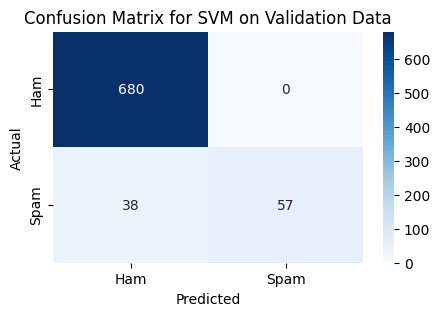

Training and evaluating Logistic Regression...


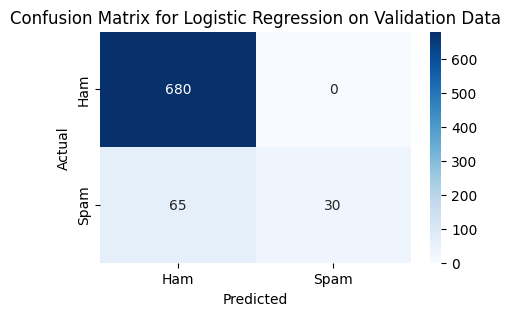

Training and evaluating Random Forest...


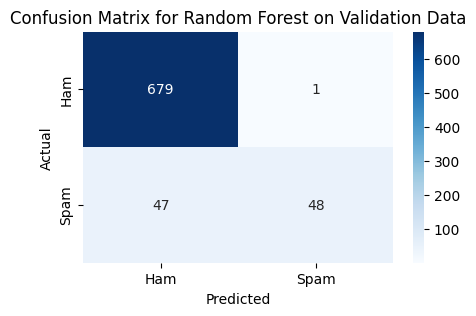

Training Data Results:
                    Accuracy Precision   Recall F1 Score CV Score
SVM                  100.00%   100.00%  100.00%  100.00%   98.18%
Logistic Regression   90.98%   100.00%   36.94%   53.95%  100.00%
Random Forest        100.00%   100.00%  100.00%  100.00%  100.00%


Validation Data Results:
                    Accuracy Precision  Recall F1 Score CV Score
SVM                   95.10%   100.00%  60.00%   75.00%   98.18%
Logistic Regression   91.61%   100.00%  31.58%   48.00%  100.00%
Random Forest         93.81%    97.96%  50.53%   66.67%  100.00%


In [ ]:
def create_pipeline(model):
    return Pipeline([('tfidf', TfidfVectorizer()), ('classifier', model)])

# Define models
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "CV Score"]
df_train = pd.DataFrame(0, index=models.keys(), columns=metrics)
df_validate = pd.DataFrame(0, index=models.keys(), columns=metrics)

for name, model in models.items():
    print(f"Training and evaluating {name}...")
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    
    # Training metrics
    y_pred_train = pipeline.predict(X_train)
    df_train.loc[name, "Accuracy"] = accuracy_score(y_train, y_pred_train) * 100
    df_train.loc[name, "Precision"] = precision_score(y_train, y_pred_train) * 100
    df_train.loc[name, "Recall"] = recall_score(y_train, y_pred_train) * 100
    df_train.loc[name, "F1 Score"] = f1_score(y_train, y_pred_train) * 100
    df_train.loc[name, "CV Score"] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision').mean() * 100
    
    # Validation metrics
    y_pred_val = pipeline.predict(X_validate)
    df_validate.loc[name, "Accuracy"] = accuracy_score(y_validate, y_pred_val) * 100
    df_validate.loc[name, "Precision"] = precision_score(y_validate, y_pred_val) * 100
    df_validate.loc[name, "Recall"] = recall_score(y_validate, y_pred_val) * 100
    df_validate.loc[name, "F1 Score"] = f1_score(y_validate, y_pred_val) * 100
    df_validate.loc[name, "CV Score"] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision').mean() * 100
    
    # Confusion matrix plot
    cm = confusion_matrix(y_validate, y_pred_val)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.title(f"Confusion Matrix for {name} on Validation Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("Training Data Results:")
print(df_train.applymap(lambda x: f"{x:.2f}%"))
print("\nValidation Data Results:")
print(df_validate.applymap(lambda x: f"{x:.2f}%"))

### Now we create pipeline but with hyperparameter tuning

In [ ]:
def create_pipeline(model):
    return Pipeline([('tfidf', TfidfVectorizer()), ('classifier', model)])

# Hyperparameters for grid search & Models definition
param_grids = {
    'SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf'], 'classifier__gamma': ['scale', 'auto']},
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l2'], 'classifier__solver': ['liblinear', 'saga']},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20],
                      'classifier__min_samples_split': [2, 5], 'classifier__min_samples_leaf': [1, 2]}
}

models = {
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

best_pipelines, best_f1_scores = {}, {}

for name, model in models.items():
    print(f"Training and tuning {name}...")
    grid = GridSearchCV(create_pipeline(model), param_grid=param_grids[name], cv=5, n_jobs=-1, verbose=1, scoring='f1')
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    best_pipelines[name] = best_pipe
    f1 = f1_score(y_validate, best_pipe.predict(X_validate), zero_division=1)
    best_f1_scores[name] = f1
    print(f"Best parameters for {name}: {grid.best_params_}\nF1 Score on Validation Data: {f1:.4f}\n")

best_model_name = max(best_f1_scores, key=best_f1_scores.get)
best_pipeline = best_pipelines[best_model_name]
print(f"\n✅ Best Model: {best_model_name} (F1-score: {best_f1_scores[best_model_name]:.4f})")

Training and tuning SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
F1 Score on Validation Data: 0.8588

Training and tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
F1 Score on Validation Data: 0.8571

Training and tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
F1 Score on Validation Data: 0.7162


✅ Best Model: SVM (F1-score: 0.8588)


### Evaluation

In [ ]:
# Evaluate the best pipeline on the test data
df_test = pd.DataFrame(np.zeros((1, 5)))  # Only for the best pipeline
df_test.index = [best_model_name]  # Index is the best model name
df_test.columns = ["Accuracy", "Precision", "Recall", "F1 Score", "CV Score"]

print(f"Evaluating Best Model ({best_model_name}) on Test Data...")

# Use the best pipeline (TF-IDF + Best Model)
y_pred_test = best_pipeline.predict(X_test)

# Compute metrics
df_test.iloc[0, 0] = accuracy_score(y_test, y_pred_test) * 100
df_test.iloc[0, 1] = precision_score(y_test, y_pred_test) * 100
df_test.iloc[0, 2] = recall_score(y_test, y_pred_test) * 100
df_test.iloc[0, 3] = f1_score(y_test, y_pred_test) * 100

# Perform cross-validation score
cv_score = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
df_test.iloc[0, 4] = cv_score.mean() * 100 

# Display results as percentages
df_display = df_test.map(lambda x: f"{x:.2f}%")
print("\n✅ Test Data Results:")
print(df_display)

Evaluating Best Model (SVM) on Test Data...

✅ Test Data Results:
    Accuracy Precision   Recall F1 Score CV Score
SVM  100.00%   100.00%  100.00%  100.00%   96.52%


## Saving the model for later usage

In [ ]:
# **Save the best pipeline**
def save_pipeline(pipeline, pipeline_path="best_model_assignment3.pkl"):
    """Saves the best pipeline (TF-IDF + Best Model) to a file."""
    os.makedirs(os.path.dirname(pipeline_path), exist_ok=True)  

    with open(pipeline_path, "wb") as file:
        pickle.dump(pipeline, file)

    print(f"\n✅ Best pipeline ({best_model_name}) saved at: {pipeline_path}")

# **User-defined file path**
pipeline_path = r"D:\aml\AppliedMachineLearning\Assignment3\model\best_model_assignment3.pkl"
save_pipeline(best_pipeline, pipeline_path)


✅ Best pipeline (SVM) saved at: D:\aml\AppliedMachineLearning\Assignment3\model\best_model_assignment3.pkl
